In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
import pdb

In [2]:
# Some colours
LIGHT_RED = '#FFC4CC'
LIGHT_GREEN = '#95FD99'
BLACK = '#000000'
WHITE = '#FFFFFF'
LIGHT_PURPLE = '#E8D0FF'
LIGHT_ORANGE = '#FAE0C3'

In [5]:
class Maze:
    # Actions
    STAY = 0
    MOVE_LEFT = 1
    MOVE_RIGHT = 2
    MOVE_UP = 3
    MOVE_DOWN = 4

    # Give names to actions
    actions_names = {
        STAY: "stay",
        MOVE_LEFT: "move left",
        MOVE_RIGHT: "move right",
        MOVE_UP: "move up",
        MOVE_DOWN: "move down"
    }

    # Reward values
    STEP_REWARD = -1
    GOAL_REWARD = 0
    IMPOSSIBLE_REWARD = -100
    DEAD_REWARD = -100
    
    def __init__(self, maze, weights=None, random_rewards=False):
        """ Constructor of the environment Maze.
        """
        self.maze = maze
        self.actions = self.__actions()
        self.states, self.map = self.__states()
        self.n_actions = len(self.actions)
        self.n_states = len(self.states)
        self.transition_probabilities = self.__transitions()
        self.rewards = self.__rewards(weights=weights)
        
    def __actions(self):
        actions = dict()
        actions[self.STAY] = (0, 0)
        actions[self.MOVE_LEFT] = (0, -1)
        actions[self.MOVE_RIGHT] = (0, 1)
        actions[self.MOVE_UP] = (-1, 0)
        actions[self.MOVE_DOWN] = (1, 0)
        return actions

    def __states(self):
        states = dict()
        map = dict()
        s = 0

        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                for i_m in range(self.maze.shape[0]):
                    for j_m in range(self.maze.shape[1]):
                        if (self.maze[i, j] != 1) & (self.maze[i_m, j_m] != 1):
                            states[s] = (i, j, i_m, j_m)
                            map[(i, j, i_m, j_m)] = s
                            s += 1
        return states, map
    
    def __move(self, state, action, p):
        row = self.states[state][0] + self.actions[action][0]
        col = self.states[state][1] + self.actions[action][1]

        hitting_maze_walls = (row == -1) or (row == self.maze.shape[0]) or \
                             (col == -1) or (col == self.maze.shape[1]) or \
                             (self.maze[row, col] == 1)
        if hitting_maze_walls:
            return self.map[(self.states[state][0], self.states[state][1], p[0], p[1])]
        else:             
            return self.map[(row, col, p[0], p[1])]

    def __possible_pos_minotaur(self, state):
        pos = list()
        for action in self.actions:
            if action == 0:
                continue
            row = self.states[state][2] + self.actions[action][0]
            col = self.states[state][3] + self.actions[action][1]
            if (row == -1) or (row == self.maze.shape[0]) or (col == -1) or (col == self.maze.shape[1]):
                continue
            elif self.maze[row,col] == 1:
                if self.maze[row + self.actions[action][0], col + self.actions[action][1]] == 0:
                    pos.append((row + self.actions[action][0], col + self.actions[action][1]))
            else:
                pos.append((row, col))                
        return pos
        
    
    def __transitions(self):
        dimensions = (self.n_states, self.n_states, self.n_actions)
        transition_probabilities = np.zeros(dimensions)
        
        for s in range(self.n_states): 
            pos_m = self.__possible_pos_minotaur(s)           
            for a in range(self.n_actions):                
                for p in pos_m:
                    next_s = self.__move(s, a, p)
                    transition_probabilities[next_s, s, a] = 1/len(pos_m)
        return transition_probabilities


    def __rewards(self, weights=None):
        rewards = np.zeros((self.n_states, self.n_actions))
        # If the rewards are not described by a weight matrix
        if weights is None:
            for s in range(self.n_states):                
                for a in range(self.n_actions):
                    pos = self.__possible_pos_minotaur(s)                     
                    for p in pos:
                        next_s = self.__move(s, a, p)
                        # Reward for hitting a wall
                        if self.states[s][0:2] == self.states[next_s][0:2] and a != self.STAY:
                            rewards[s, a] += self.IMPOSSIBLE_REWARD
                        # Reward for reaching the exit
                        elif self.states[s][0:2] == self.states[next_s][0:2] and self.maze[self.states[next_s][0:2]] == 2:
                            rewards[s, a] += self.GOAL_REWARD
                        # Reward if the minotaur eats the user
                        elif (self.states[s][0] == self.states[s][2]) and (self.states[s][1] == self.states[s][3]):
                            rewards[s, a] += self.DEAD_REWARD
                        # Reward for taking a step to an empty cell that is not the exit
                        else:
                            rewards[s, a] += self.STEP_REWARD
                            
                    rewards[s, a] /= len(pos)
        # If the weights are described by a weight matrix
        else:
            for s in range(self.n_states):
                for a in range(self.n_actions):
                    next_s = self.__move(s, a)
                    i, j = self.states[next_s]
                    # Simply put the reward as the weights o the next state.
                    rewards[s, a] = weights[i][j]
        return rewards


    def simulate(self, start, policy, method):
        path = list()
        
        if method == 'DynProg':
            # Deduce the horizon from the policy shape
            horizon = policy.shape[1]
            # Initialize current state and time
            t = 0
            s = self.map[start]
            # Add the starting position in the maze to the path
            path.append(start)            
            while t < horizon - 1:
                # Move to next state given the policy and the current state
                 
                pos = self.__possible_pos_minotaur(s)

                next_s = self.__move(s, policy[s, t], random.choice(pos))
                # Add the position in the maze corresponding to the next state
                # to the path'numpy.ndarray' object is not callable
                path.append(self.states[next_s])
                # Update time and state for next iteration
                t += 1
                s = next_s
        
        return path
    
    def show(self):
        print('The states are :')
        print(self.states)
        print('The actions are:')
        print(self.actions)
        print('The mapping of the states:')
        print(self.map)
        print('The rewards:')
        print(self.rewards)


In [6]:
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]
])

env = Maze(maze)


In [7]:
def dynamic_programming(env, horizon):
    p = env.transition_probabilities
    r = env.rewards
    T = horizon
    n_states = env.n_states
    n_actions = env.n_actions
    
    # The variables involved in the dynamic programming backwards recursions
    V = np.zeros((n_states, T + 1))
    policy = np.zeros((n_states, T + 1))
    Q = np.zeros((n_states, n_actions))
    
    print(r.shape)
    #Initialization
    Q = np.copy(r)
    V[:, T] = np.max(Q, 1)
    policy[:, T] = np.argmax(Q, 1)
    
    # The dynamic programming backwards recursion
    for t in range(T - 1, -1, -1):
        for s in range(n_states):
            for a in range(n_actions):
                Q[s, a] = r[s, a] + np.dot(p[:, s, a], V[:, t + 1])
                
        # Update by taking the maximum Q value w.r.t the action a
        V[:, t] = np.max(Q, 1)
        policy[:, t] = np.argmax(Q, 1)    
    
    return V, policy

    
def value_iteration(env, gamma, epsilon):
    p = env.transition_probabilities
    r = env.rewards
    n_states = env.n_states
    n_actions = env.n_actions
    
    V = np.zeros(n_states)    
    Q = np.zeros((n_states, n_actions))
    BV = np.zeros(n_states)
    
    n = 0
    # Tolerance error
    tol = (1 - gamma) * epsilon / gamma
    for s in range(n_states):
        for a in range(n_actions):
            Q[s, a] = r[s, a] + gamma * np.dot(p[:, s, a], V)
    BV = np.max(Q, 1)            
    
    # Iterate until convergence
    while np.linalg.norm(V - BV) >= tol and n < 200:
        # Increment by one the numbers of iteration
        n += 1;
        # Update the value function
        V = np.copy(BV);
        # Compute the new BV
        for s in range(n_states):
            for a in range(n_actions):
                Q[s, a] = r[s, a] + gamma * np.dot(p[:, s, a], V);
        BV = np.max(Q, 1);
        # Show error
        # print(np.linalg.norm(V - BV))

    # Compute policy
    policy = np.argmax(Q, 1);
    # Return the obtained policy
    return V, policy;

def draw_maze(maze):
    # Map a color to each cell in the maze
    col_map = {0: WHITE, 1: BLACK, 2: LIGHT_GREEN, -6: LIGHT_RED, -1: LIGHT_RED}

    # Give a color to each cell
    rows, cols = maze.shape
    colored_maze = [[col_map[maze[j, i]] for i in range(cols)] for j in range(rows)]

    # Create figure of the size of the maze
    fig = plt.figure(1, figsize=(cols, rows));

    # Remove the axis ticks and add title title
    ax = plt.gca()
    ax.set_title('The Maze')
    ax.set_xticks([])
    ax.set_yticks([])

    # Give a color to each cell
    rows, cols = maze.shape
    colored_maze = [[col_map[maze[j, i]] for i in range(cols)] for j in range(rows)]

    # Create figure of the size of the maze
    fig = plt.figure(1, figsize=(cols, rows))

    # Create a table to color
    grid = plt.table(cellText=None,
                     cellColours=colored_maze,
                     cellLoc='center',
                     loc=(0, 0),
                     edges='closed')
    # Modify the height and width of the cells in the table
    tc = grid.properties()['children']
    for cell in tc:
        cell.set_height(1.0 / rows);
        cell.set_width(1.0 / cols);


def animate_solution(maze, path):
    # Map a color to each cell in the maze
    col_map = {0: WHITE, 1: BLACK, 2: LIGHT_GREEN, -6: LIGHT_RED, -1: LIGHT_RED};

    # Size of the maze
    rows, cols = maze.shape

    # Create figure of the size of the maze
    fig = plt.figure(1, figsize=(cols, rows))

    # Remove the axis ticks and add title title
    ax = plt.gca()
    ax.set_title('Policy simulation')
    ax.set_xticks([])
    ax.set_yticks([])

    # Give a color to each cell
    colored_maze = [[col_map[maze[j, i]] for i in range(cols)] for j in range(rows)];

    # Create figure of the size of the maze
    fig = plt.figure(1, figsize=(cols, rows))

    # Create a table to color
    grid = plt.table(cellText=None,
                     cellColours=colored_maze,
                     cellLoc='center',
                     loc=(0, 0),
                     edges='closed')
    # Modify the hight and width of the cells in the table
    tc = grid.properties()['children']
    for cell in tc:
        cell.set_height(1.0 / rows)
        cell.set_width(1.0 / cols)

    # Update the color at each frame PLAYER
    for i in range(len(path)):
        grid.get_celld()[(path[i][0:2])].set_facecolor(LIGHT_ORANGE)
        grid.get_celld()[(path[i][0:2])].get_text().set_text('Player')
        
        grid.get_celld()[(path[i][2:4])].set_facecolor(LIGHT_ORANGE)
        grid.get_celld()[(path[i][2:4])].get_text().set_text('MINOTAUR')
        
        if i > 0:
            grid.get_celld()[(path[i - 1][2:4])].set_facecolor(col_map[maze[path[i - 1][2:4]]])
            grid.get_celld()[(path[i - 1][2:4])].get_text().set_text('')
            
            if path[i][0:2] == path[i - 1][0:2]:
                grid.get_celld()[(path[i][0:2])].set_facecolor(LIGHT_GREEN)
                grid.get_celld()[(path[i][0:2])].get_text().set_text('Player is out')
                
            elif path[i][0:2] == path[i][2:4]:
                grid.get_celld()[(path[i])].set_facecolor(LIGHT_RED)
                grid.get_celld()[(path[i])].get_text().set_text('KILLED')
                
            else:
                grid.get_celld()[(path[i - 1][0:2])].set_facecolor(col_map[maze[path[i - 1][0:2]]])
                grid.get_celld()[(path[i - 1][0:2])].get_text().set_text('')
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(1)



In [8]:
horizon = 20
V, policy = dynamic_programming(env, horizon)
print(policy)

method = 'DynProg'
start  = (0, 0, 6, 5)
path = env.simulate(start, policy, method)

print(path)


(1600, 5)
[[0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 0.]
 [4. 4. 4. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[(0, 0, 6, 5), (1, 0, 6, 3), (2, 0, 6, 2), (2, 1, 6, 1), (3, 1, 4, 1), (4, 1, 4, 2), (4, 2, 4, 1), (4, 3, 3, 1), (4, 4, 3, 3), (4, 5, 2, 3), (4, 6, 2, 1), (4, 7, 1, 1), (5, 7, 1, 0), (6, 7, 1, 1), (6, 6, 2, 1), (6, 5, 1, 1), (6, 5, 2, 1), (6, 5, 1, 1), (6, 5, 2, 1), (6, 5, 2, 0), (6, 5, 2, 1)]


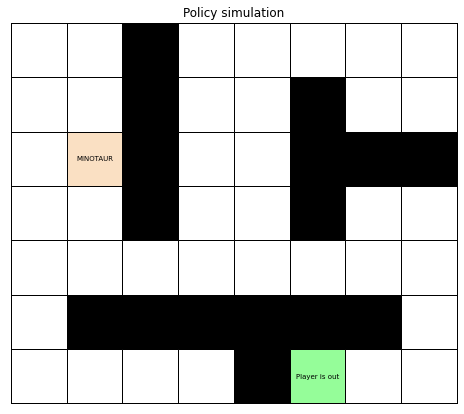

In [9]:
animate_solution(maze, path)